In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from random import sample
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess
from tensorflow.keras.models import Model
from pathlib import Path
Image.LOAD_TRUNCATED_IMAGES = True
import requests
                
from io import BytesIO
from tqdm.auto import tqdm
import os

In [12]:
# Read the data files
listing_data = pd.read_csv("data/current_farfetch_listings.csv")

In [13]:
listing_data.head()

Unnamed: 0                                     availableSizes  brand.id  \
0           0                                                NaN      8360   
1           1  [{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...   2049368   
2           2                                                NaN     15514   
3           3               [{'scaleId': 0, 'size': 'One Size'}]     49486   
4           4                                                NaN     34624   

      brand.name gender  hasSimilarProducts        id  \
0        Miu Miu  women                True  13415450   
1  Self-Portrait  women                True  13784566   
2          Fendi  women                True  13377441   
3         A.P.C.  women               False  13744082   
4          Prada  women                True  13668256   

                                       images.cutOut  \
0  https://cdn-images.farfetch-contents.com/13/41...   
1  https://cdn-images.farfetch-contents.com/13/78...   
2  https://cdn-images.farfetch-contents.com/13/37...   
3  https://cdn-images.farfetch-contents.com/13/74...   
4  https://cdn-images.farfetch-contents.com/13/66...   

                                        images.model  isCustomizable  ...  \
0  https://cdn-images.farfetch-contents.com/13/41...           False  ...   
1  https://cdn-images.farfetch-contents.com/13/78...           False  ...   
2  https://cdn-images.farfetch-contents.com/13/37...           False  ...   
3  https://cdn-images.farfetch-contents.com/13/74...           False  ...   
4  https://cdn-images.farfetch-contents.com/13/66...           False  ...   

  priceInfo.currencyCode priceInfo.discountLabel  priceInfo.finalPrice  \
0                    SGD                     NaN                  1080   
1                    SGD                 20% Off                   392   
2                    SGD                     NaN                  1245   
3                    SGD                 20% Off                   308   
4                    SGD                     NaN                  1248   

  priceInfo.formattedFinalPrice priceInfo.formattedInitialPrice  \
0                        $1,080                          $1,080   
1                          $392                            $490   
2                        $1,245                          $1,245   
3                          $308                            $385   
4                        $1,248                          $1,248   

   priceInfo.initialPrice priceInfo.installmentsLabel priceInfo.isOnSale  \
0                    1080                         NaN              False   
1                     490                         NaN               True   
2                    1245                         NaN              False   
3                     385                         NaN               True   
4                    1248                         NaN              False   

                 shortDescription  stockTotal  
0       logo print strap sandals          130  
1          embroidered midi dress          14  
2  FendiMania sock style sneakers          68  
3                  top zip wallet           1  
4              slingback 65 pumps          78  

[5 rows x 23 columns]

In [4]:
listing_data.shape

(188817, 23)

In [5]:
listing_data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188817 entries, 0 to 188816
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   availableSizes                   162711 non-null  object 
 1   brand.id                         188817 non-null  int64  
 2   brand.name                       188817 non-null  object 
 3   gender                           188817 non-null  object 
 4   hasSimilarProducts               188817 non-null  bool   
 5   id                               188817 non-null  int64  
 6   images.cutOut                    188817 non-null  object 
 7   images.model                     188817 non-null  object 
 8   isCustomizable                   188817 non-null  bool   
 9   merchandiseLabel                 56441 non-null   object 
 10  merchandiseLabelField            188817 non-null  object 
 11  merchantId                       188817 non-null  int64  
 12  pr

In [7]:
listing_data.drop('priceInfo.installmentsLabel', axis=1, inplace=True)

In [8]:
# Check for % of null values
listing_data.isnull().sum() * 100 / listing_data.shape[0] 

availableSizes                     13.826086
brand.id                            0.000000
brand.name                          0.000000
gender                              0.000000
hasSimilarProducts                  0.000000
id                                  0.000000
images.cutOut                       0.000000
images.model                        0.000000
isCustomizable                      0.000000
merchandiseLabel                   70.108094
merchandiseLabelField               0.000000
merchantId                          0.000000
priceInfo.currencyCode              0.000000
priceInfo.discountLabel            63.834295
priceInfo.finalPrice                0.000000
priceInfo.formattedFinalPrice       0.000000
priceInfo.formattedInitialPrice     0.000000
priceInfo.initialPrice              0.000000
priceInfo.isOnSale                  0.000000
shortDescription                    0.000000
stockTotal                          0.000000
dtype: float64

In [9]:
# Analyse the null variables
listing_data[~listing_data['merchandiseLabel'].isnull()].head()

availableSizes  brand.id  \
9   [{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...   1504165   
11  [{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...      2747   
13  [{'scaleId': 0, 'size': 'L'}, {'scaleId': 0, '...    168996   
15                                                NaN    769627   
18  [{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...      2765   

                       brand.name gender  hasSimilarProducts        id  \
9                      Rejina Pyo  women                True  13777585   
11                          Chloé  women                True  13704528   
13  Pleats Please By Issey Miyake  women                True  14107224   
15                       Burberry  women                True  13970008   
18              Alexander McQueen  women                True  13951735   

                                        images.cutOut  \
9   https://cdn-images.farfetch-contents.com/13/77...   
11  https://cdn-images.farfetch-contents.com/13/70...   
13  https://cdn-images.farfetch-contents.com/14/10...   
15  https://cdn-images.farfetch-contents.com/13/97...   
18  https://cdn-images.farfetch-contents.com/13/95...   

                                         images.model  isCustomizable  \
9   https://cdn-images.farfetch-contents.com/13/77...           False   
11  https://cdn-images.farfetch-contents.com/13/70...           False   
13  https://cdn-images.farfetch-contents.com/14/10...           False   
15  https://cdn-images.farfetch-contents.com/13/97...           False   
18  https://cdn-images.farfetch-contents.com/13/95...           False   

   merchandiseLabel  ... merchantId  priceInfo.currencyCode  \
9        New Season  ...       9359                     SGD   
11       New Season  ...       9359                     SGD   
13       New Season  ...       9359                     SGD   
15       New Season  ...       9359                     SGD   
18       New Season  ...       9359                     SGD   

   priceInfo.discountLabel priceInfo.finalPrice  \
9                      NaN                  989   
11                     NaN                 1790   
13                     NaN                  657   
15                     NaN                 1000   
18                     NaN                 3330   

    priceInfo.formattedFinalPrice priceInfo.formattedInitialPrice  \
9                            $989                            $989   
11                         $1,790                          $1,790   
13                           $657                            $657   
15                         $1,000                          $1,000   
18                         $3,330                          $3,330   

   priceInfo.initialPrice  priceInfo.isOnSale  \
9                     989               False   
11                   1790               False   
13                    657               False   
15                   1000               False   
18                   3330               False   

                   shortDescription stockTotal  
9      Blake herringbone midi dress         16  
11   pussy-bow rose-jacquard blouse         14  
13               pleated midi dress         13  
15   Margrette 50mm cow print pumps         10  
18  tie-neck houndstooth midi-dress          2  

[5 rows x 21 columns]

In [10]:
# Check for the categories in merchandiseLabel
listing_data['merchandiseLabel'].value_counts()

merchandiseLabel
New Season              41469
Positively Conscious    12324
Permanent Collection     1275
Seasonal Pick             741
Exclusive                 632
Name: count, dtype: int64

In [11]:
# Drop the column merchandiseLabel
listing_data.drop('merchandiseLabel', axis=1, inplace=True)

In [12]:
# Analysing priceInfo.discountLabel
listing_data[listing_data['priceInfo.discountLabel'].isnull()].head()

availableSizes  brand.id brand.name gender  \
0                                   NaN      8360    Miu Miu  women   
2                                   NaN     15514      Fendi  women   
4                                   NaN     34624      Prada  women   
6  [{'scaleId': 0, 'size': 'One Size'}]     25354      Gucci  women   
7  [{'scaleId': 0, 'size': 'One Size'}]   1025204        MCM  women   

   hasSimilarProducts        id  \
0                True  13415450   
2                True  13377441   
4                True  13668256   
6                True  12562558   
7                True  13768073   

                                       images.cutOut  \
0  https://cdn-images.farfetch-contents.com/13/41...   
2  https://cdn-images.farfetch-contents.com/13/37...   
4  https://cdn-images.farfetch-contents.com/13/66...   
6  https://cdn-images.farfetch-contents.com/12/56...   
7  https://cdn-images.farfetch-contents.com/13/76...   

                                        images.model  isCustomizable  \
0  https://cdn-images.farfetch-contents.com/13/41...           False   
2  https://cdn-images.farfetch-contents.com/13/37...           False   
4  https://cdn-images.farfetch-contents.com/13/66...           False   
6  https://cdn-images.farfetch-contents.com/12/56...           False   
7  https://cdn-images.farfetch-contents.com/13/76...           False   

  merchandiseLabelField  merchantId priceInfo.currencyCode  \
0                 NoTag        9359                    SGD   
2                 NoTag        9140                    SGD   
4                 NoTag        9339                    SGD   
6                 NoTag       10952                    SGD   
7                 NoTag        9913                    SGD   

  priceInfo.discountLabel  priceInfo.finalPrice priceInfo.formattedFinalPrice  \
0                     NaN                  1080                        $1,080   
2                     NaN                  1245                        $1,245   
4                     NaN                  1248                        $1,248   
6                     NaN                  3740                        $3,740   
7                     NaN                  1323                        $1,323   

  priceInfo.formattedInitialPrice  priceInfo.initialPrice  priceInfo.isOnSale  \
0                          $1,080                    1080               False   
2                          $1,245                    1245               False   
4                          $1,248                    1248               False   
6                          $3,740                    3740               False   
7                          $1,323                    1323               False   

                              shortDescription  stockTotal  
0                    logo print strap sandals          130  
2               FendiMania sock style sneakers          68  
4                           slingback 65 pumps          78  
6  Green Dionysus GG small velvet shoulder bag          61  
7                           logo print satchel           5

In [13]:
# fill the null values in priceInfo.discountLabel with 0
listing_data['priceInfo.discountLabel'] = listing_data['priceInfo.discountLabel'].fillna(0)

In [14]:
# drop the size column
listing_data.drop('availableSizes', axis=1, inplace=True)

In [15]:
# Check for null values again
listing_data.isnull().sum()

brand.id                           0
brand.name                         0
gender                             0
hasSimilarProducts                 0
id                                 0
images.cutOut                      0
images.model                       0
isCustomizable                     0
merchandiseLabelField              0
merchantId                         0
priceInfo.currencyCode             0
priceInfo.discountLabel            0
priceInfo.finalPrice               0
priceInfo.formattedFinalPrice      0
priceInfo.formattedInitialPrice    0
priceInfo.initialPrice             0
priceInfo.isOnSale                 0
shortDescription                   0
stockTotal                         0
dtype: int64

In [16]:
def assign_product_category(description):
    label = list(description.split())[-1].lower()
    
    return label
listing_data['product_category']=listing_data["shortDescription"].map(lambda x: assign_product_category(x))

In [17]:
# Extracting the Image 
def load_images():
    
    # Store the directory path in a varaible
    cutout_img_dir = "data/cutout"
    model_img_dir = "data/model"
    
    # list the images in these directories
    cutout_images = os.listdir(cutout_img_dir)
    model_images = os.listdir(model_img_dir)
    
    # load 10 Random Cutout Images: Sample out 10 images randomly from the above list
    sample_cutout_images = sample(cutout_images,10)
    fig = plt.figure(figsize=(10, 5))
    
    print("==============Cutout Images==============")
    for i, img_name in enumerate(sample_cutout_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(cutout_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()
    print()
    # load 10 Random Model Images: Sample out 10 images randomly from the above list
    sample_model_images = sample(model_images,10)
    fig = plt.figure(figsize=(10,5))
    
    print("==============Model Images==============")
    for i, img_name in enumerate(sample_model_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(model_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()

==============Cutout Images==============


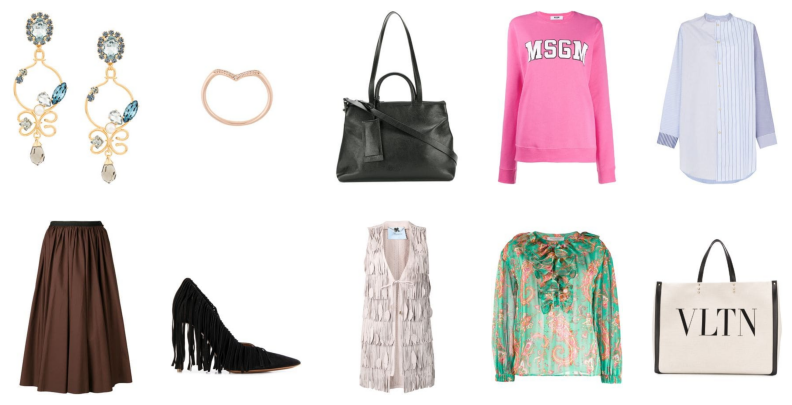


==============Model Images==============


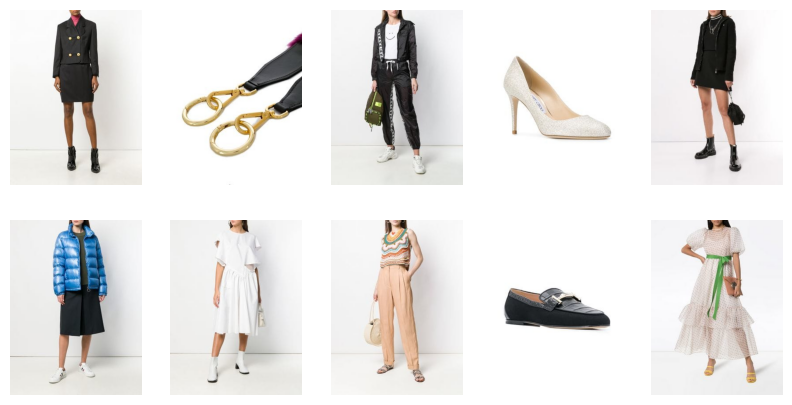

In [18]:
load_images()

In [19]:
# Join the images with path and add in the dataframe

# Store the directory path in a varaible
cutout_img_dir = "data/cutout"
model_img_dir = "data/model"

# list the directories
cutout_images = os.listdir(cutout_img_dir)
model_images = os.listdir(model_img_dir)

In [21]:
def extractImageName(x):
    
    # 1. Invert the image path
    x_inv = x[ :: -1]
    
    # 2. Find the index of '/'
    slash_idx = x_inv.find('/')
    
    # 3. Extract the text after the -slash_idx
    return x[-slash_idx : ] 

listing_data['cutOutimageNames'] = listing_data['images.cutOut'].apply(lambda x : extractImageName(x))
listing_data['modelimageNames'] = listing_data['images.model'].apply(lambda x : extractImageName(x))

In [22]:
# Extract only those data points for which we have images
listing_data = listing_data[listing_data['cutOutimageNames'].isin(cutout_images)]
listing_data = listing_data[listing_data['modelimageNames'].isin(model_images)]

In [23]:
# Reset the index
listing_data.reset_index(drop=True, inplace=True)

In [24]:
# Add entire paths to cutOut and modelImages
listing_data['cutOutImages_path'] = cutout_img_dir + '/' + listing_data['cutOutimageNames']
listing_data['modelImages_path'] = model_img_dir + '/' + listing_data['modelimageNames']

In [25]:
# Drop the cutOutimageNames, cutOutimageNames
listing_data.drop(['cutOutimageNames', 'cutOutimageNames'], axis=1, inplace=True)

The images show a Mano tray
Price: $1,012
Brand: Fornasetti



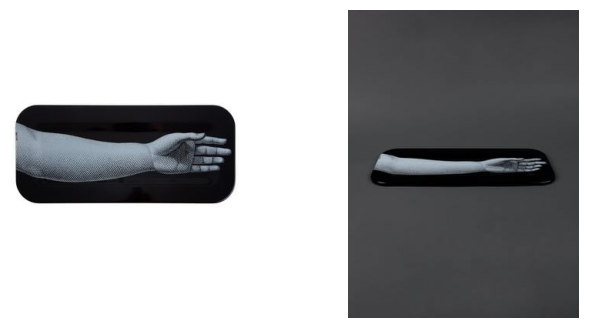

In [26]:
# Plot the images along with product descriptions, price and brand
random_idx = np.random.randint(low = 0, high = listing_data.shape[0] - 1)
cutOut_img_path = listing_data.iloc[random_idx]['cutOutImages_path']
model_img_path = listing_data.iloc[random_idx]['modelImages_path']
price = listing_data.iloc[random_idx]['priceInfo.formattedFinalPrice']
desc = listing_data.iloc[random_idx]['shortDescription']
brand = listing_data.iloc[random_idx]['brand.name']

# Load the images
cutOut_img = image.load_img(cutOut_img_path)
cutOut_img_arr = image.img_to_array(cutOut_img, dtype='int')
model_img = image.load_img(model_img_path)
model_img_arr = image.img_to_array(model_img, dtype='int')

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
print("The images show a {}".format(desc))
print("Price: {}".format(price))
print("Brand: {}".format(brand))
print()
ax[0].imshow(cutOut_img_arr)
ax[1].imshow(model_img_arr)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [29]:
print(listing_data['product_category'].value_counts())

product_category
dress          18999
bag            15561
trousers        9302
top             8296
sunglasses      7148
               ...  
neckring           1
bloomers           1
lr-090/cb          1
lr-089/cb          1
breastplate        1
Name: count, Length: 1683, dtype: int64


In [30]:
my_dict=dict()
for label in listing_data["product_category"]:
    try:
        my_dict[label]+=1
    except:
        my_dict[label]=1
choosen_category=[]
for key in my_dict.keys():
    if my_dict[key]>=100:
        choosen_category.append(key)

In [31]:
sub_listing_data=listing_data[listing_data['product_category'].isin(choosen_category)]
sub_listing_data

brand.id     brand.name  gender  hasSimilarProducts        id  \
0           8360        Miu Miu   women                True  13415450   
1        2049368  Self-Portrait   women                True  13784566   
2          15514          Fendi   women                True  13377441   
3          49486         A.P.C.   women               False  13744082   
4          34624          Prada   women                True  13668256   
...          ...            ...     ...                 ...       ...   
188812     59394     Fornasetti  unisex               False  10047577   
188813     59394     Fornasetti  unisex               False  10047571   
188814     59394     Fornasetti  unisex               False  10047569   
188815     59394     Fornasetti  unisex               False  10047567   
188816     59394     Fornasetti  unisex               False  10047563   

                                            images.cutOut  \
0       https://cdn-images.farfetch-contents.com/13/41...   
1       https://cdn-images.farfetch-contents.com/13/78...   
2       https://cdn-images.farfetch-contents.com/13/37...   
3       https://cdn-images.farfetch-contents.com/13/74...   
4       https://cdn-images.farfetch-contents.com/13/66...   
...                                                   ...   
188812  https://cdn-images.farfetch-contents.com/10/04...   
188813  https://cdn-images.farfetch-contents.com/10/04...   
188814  https://cdn-images.farfetch-contents.com/10/04...   
188815  https://cdn-images.farfetch-contents.com/10/04...   
188816  https://cdn-images.farfetch-contents.com/10/04...   

                                             images.model  isCustomizable  \
0       https://cdn-images.farfetch-contents.com/13/41...           False   
1       https://cdn-images.farfetch-contents.com/13/78...           False   
2       https://cdn-images.farfetch-contents.com/13/37...           False   
3       https://cdn-images.farfetch-contents.com/13/74...           False   
4       https://cdn-images.farfetch-contents.com/13/66...           False   
...                                                   ...             ...   
188812  https://cdn-images.farfetch-contents.com/10/04...           False   
188813  https://cdn-images.farfetch-contents.com/10/04...           False   
188814  https://cdn-images.farfetch-contents.com/10/04...           False   
188815  https://cdn-images.farfetch-contents.com/10/04...           False   
188816  https://cdn-images.farfetch-contents.com/10/04...           False   

       merchandiseLabelField  merchantId  ... priceInfo.formattedFinalPrice  \
0                      NoTag        9359  ...                        $1,080   
1                      NoTag        9319  ...                          $392   
2                      NoTag        9140  ...                        $1,245   
3                      NoTag        9031  ...                          $308   
4                      NoTag        9339  ...                        $1,248   
...                      ...         ...  ...                           ...   
188812                 NoTag        9089  ...                          $207   
188813                 NoTag        9089  ...                          $207   
188814                 NoTag        9089  ...                          $207   
188815                 NoTag        9089  ...                          $207   
188816                 NoTag        9089  ...                          $207   

       priceInfo.formattedInitialPrice  priceInfo.initialPrice  \
0                               $1,080                    1080   
1                                 $490                     490   
2                               $1,245                    1245   
3                                 $385                     385   
4                               $1,248                    1248   
...                                ...                     ...   
188812                            $207                     207

In [32]:
sub_listing_data.product_category.value_counts()

product_category
dress         18999
bag           15561
trousers       9302
top            8296
sunglasses     7148
              ...  
camisole        107
detail          107
hoops           105
glass           104
poncho          103
Name: count, Length: 100, dtype: int64

In [47]:
def map_labels(label):
    # Declare the main groups and their synonyms
    label_groups = {
        'glasses': ['glasses', 'sunglasses'],
        'socks': ['socks'],
        'watch': ['watch'],
        'sandals': ['sandals', 'slides'],
        'shoes': ['sneakers', 'boots', 'loafers', 'ballerinas', 'espadrilles', 'flats', 'trainers', 'booties', 'slippers', 'shoes'],
        'highheels': ['pumps', 'mules'],
        'wallet': ['wallet', 'purse', 'cardholder', 'holder'],
        'handbag': ['bag', 'satchel', 'clutch', 'tote', 'pouch', 'handbag', 'crossbody'],
        'backpack': ['backpack'],
        'keyring': ['keyring'],
        'strap': ['strap'],
        'phonecase': ['case'],
        'blouse': ['blouse', 'top', 'tunic'],
        'tshirt': ['t-shirt', 'shirt'],
        'sweater': ['sweater', 'cardigan', 'jumper', 'sweatshirt', 'pullover', 'hoodie'],
        'camisole': ['camisole'],
        'pants': ['trousers', 'pants', 'culottes', 'bottoms', 'bottom'],
        'jeans': ['jeans'],
        'shorts': ['shorts'],
        'skirt': ['skirt', 'gown', 'dress'],
        'leggings': ['leggings'],
        'underwear': ['briefs', 'thong'],
        'coat': ['coat', 'blazer', 'parka', 'raincoat'],
        'jacket': ['jacket', 'cape'],
        'vest': ['vest', 'suit'],
        'waistcoat': ['waistcoat', 'gilet'],
        'poncho': ['poncho', 'shawl'],
        'bra': ['bra'],
        'bodysuit': ['bodysuit', 'body'],
        'jumpsuit': ['jumpsuit', 'playsuit'],
        'swimsuit': ['swimsuit', 'bikini'],
        'scarf': ['scarf'],
        'hat': ['hat', 'cap'],
        'gloves': ['gloves'],
        'headband': ['headband'],
        'jewelry': ['hoops', 'ring', 'brooch', 'cuff', 'bangle', 'bracelet', 'earring', 'earrings'],
        'necklace': ['necklace', 'pendant'],
        'belt': ['belt'],
        'charm': ['charm'],
        'beanie': ['beanie'],
        'candle': ['candle'],
        'glass': ['glass'],
        'plate': ['plate'],
        'unknown': ['detail', 'set']
    }
    
    # Check each group and its synonyms
    for group, labels in label_groups.items():
        if label in labels:  # If the label belongs to the current group
            return group  # Return the corresponding group name
    
    # Return the original label if no match is found
    return 'unknown'


In [48]:
train_dict=dict()
train_index=[]
for i in range(len(sub_listing_data)):
    label=sub_listing_data.iloc[i]['product_category']
    try: 
        train_dict[label]+=1
    except:
        train_dict[label]=1
    if train_dict[label]<=80:
        train_index.append(i)

In [49]:
train_index[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [50]:
train_data=sub_listing_data.iloc[train_index]

In [51]:
len(train_data)

8000

In [52]:
train_data.product_category.value_counts()

product_category
sandals       80
pendant       80
brooch        80
gilet         80
case          80
              ..
swimsuit      80
ballerinas    80
shoes         80
jumper        80
plate         80
Name: count, Length: 100, dtype: int64

In [53]:
indexes_to_drop = train_data[(train_data['product_category'] == 'detail') | (train_data['product_category'] == 'set')].index
train_data=train_data.drop(indexes_to_drop)

In [54]:
train_data.shape

(7840, 23)

In [55]:
train_data["product_category"]=train_data["product_category"].map(lambda x: map_labels(x))

In [56]:
train_data['product_category'].value_counts()

product_category
shoes        800
jewelry      640
handbag      560
sweater      480
pants        400
wallet       320
coat         320
blouse       240
skirt        240
underwear    160
vest         160
waistcoat    160
glasses      160
jumpsuit     160
bodysuit     160
jacket       160
poncho       160
sandals      160
necklace     160
swimsuit     160
hat          160
highheels    160
tshirt       160
glass         80
candle        80
camisole      80
watch         80
keyring       80
scarf         80
beanie        80
phonecase     80
socks         80
charm         80
leggings      80
strap         80
gloves        80
backpack      80
headband      80
jeans         80
bra           80
belt          80
shorts        80
plate         80
Name: count, dtype: int64

In [58]:
train_data.to_csv("data/working/train_data.csv")

In [59]:
test_dict=dict()
test_index=[]
for i in range(len(sub_listing_data)):
    if i in train_index: continue
    label=sub_listing_data.iloc[i]['product_category']
    try: 
        test_dict[label]+=1
    except:
        test_dict[label]=1
    if test_dict[label]<=20:
        test_index.append(i)


In [60]:
test_data=sub_listing_data.iloc[test_index]
indexes_to_drop = test_data[(test_data['product_category'] == 'detail') | (test_data['product_category'] == 'set')].index
test_data=test_data.drop(indexes_to_drop)


In [61]:
test_data["product_category"]=test_data["product_category"].map(lambda x: map_labels(x))


In [62]:
test_data['product_category'].value_counts()


product_category
shoes        200
jewelry      160
handbag      140
sweater      120
pants        100
coat          80
wallet        80
skirt         60
blouse        60
poncho        40
underwear     40
waistcoat     40
bodysuit      40
vest          40
swimsuit      40
jumpsuit      40
hat           40
highheels     40
necklace      40
jacket        40
glasses       40
sandals       40
tshirt        40
belt          20
candle        20
camisole      20
headband      20
charm         20
glass         20
strap         20
beanie        20
keyring       20
watch         20
backpack      20
jeans         20
gloves        20
phonecase     20
bra           20
socks         20
scarf         20
leggings      20
shorts        20
plate         20
Name: count, dtype: int64

In [63]:
test_data['product_category'].count()

np.int64(1960)

In [64]:
test_data.to_csv("data/working/test_data.csv")

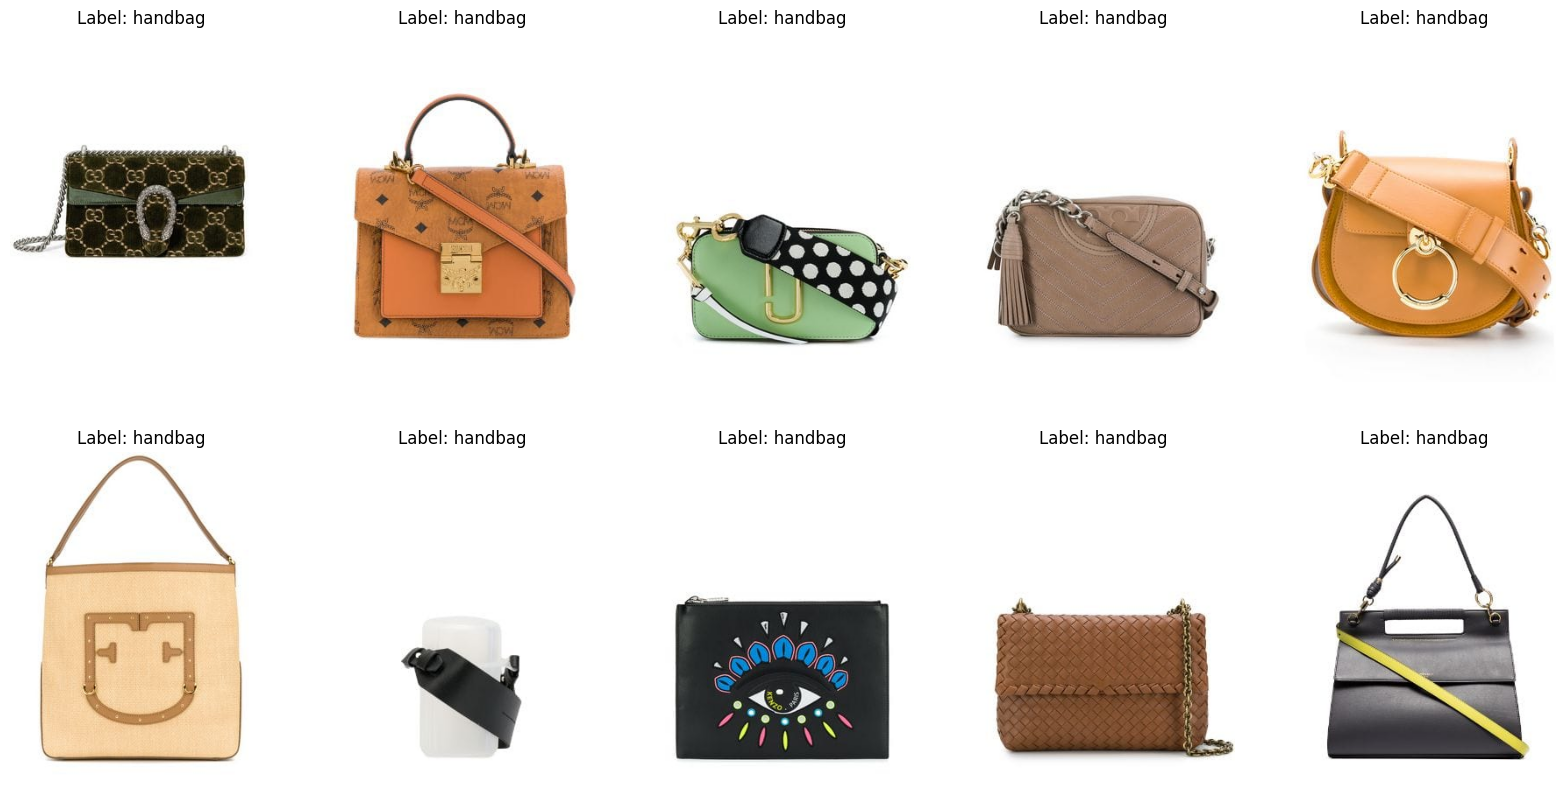

In [65]:
def show_image(train_data, label, column='product_category'):
    # Lọc các ảnh có nhãn bằng label
    filtered_data = train_data[train_data[column] == label]
    
    # Lấy ra 10 ảnh đầu tiên
    sample_data = filtered_data.head(10)
    
    # Hiển thị các ảnh
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(sample_data['cutOutImages_path']):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {label}")
    plt.show()
show_image(train_data,"handbag")

In [66]:
# Creating a class for feature extraction and finding the most similar images

'''
Comparing 3 different models

1. VGG 16
2. ResNet 50
3. Xception
'''

class FeatureExtractor:
    
    # Constructor
    def __init__(self, arch='VGG'):
        
        self.arch = arch
        
        # Using VGG -16 as the architecture with ImageNet weights
        if self.arch == 'VGG' :
            base_model = VGG16(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc1').output)
        
        # Using the ResNet 50 as the architecture with ImageNet weights
        elif self.arch == 'ResNet':
            base_model = ResNet50(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
        
        # Using the Xception as the architecture with ImageNet weights
        elif self.arch == 'Xception':
            base_model = Xception(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
            
    
    # Method to extract image features
    def extract_features(self, img):
        
        # The VGG 16 & ResNet 50 model has images of 224,244 as input while the Xception has 299, 299
        if self.arch == 'VGG' or self.arch == 'ResNet':
            img = img.resize((224, 224))
        elif self.arch == 'Xception':
            img = img.resize((299, 299))
        
        # Convert the image channels from to RGB
        img = img.convert('RGB')
        
        # Convert into array
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        if self.arch == 'VGG':
            # Proprocess the input as per vgg 16
            x = vgg_preprocess(x)
            
        elif self.arch == 'ResNet':
            # Proprocess the input as per ResNet 50
            x = resnet_preprocess(x)
            
        elif self.arch == 'Xception':
            # Proprocess the input as per ResNet 50
            x = xception_preprocess(x)
        
        
        # Extract the features
        features = self.model.predict(x) 
        
        # Scale the features
        features = features / np.linalg.norm(features)
        
        return features

In [67]:
train_data=train_data.reset_index()
test_data=test_data.reset_index()

In [68]:
cutOutImages_train=train_data["cutOutImages_path"]
labels_train=train_data["product_category"]

In [26]:
# # Extract the features for a sample of 10000 images
# index_values = np.random.randint(low = 0, high = listing_data.shape[0]-1, size = 10000)
# modelImages = listing_data.iloc[index_values]['modelImages_path']

In [69]:
cutOutImages_test=test_data["cutOutImages_path"]
labels_test=test_data["product_category"]

In [70]:
resnet_feature_extractor = FeatureExtractor(arch='ResNet')
vgg_feature_extractor = FeatureExtractor(arch='VGG')
xception_feature_extractor = FeatureExtractor(arch='Xception')

In [74]:
X_train,y_train=[],[]
for i,(img_path,label) in tqdm(enumerate(zip(cutOutImages_train, labels_train))):
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = resnet_feature_extractor.extract_features(img) 
    X_train.append(feature)
    y_train.append(label)
    # print(f"{i} success")
    
X_train = np.array(X_train)
y_train = np.array(y_train)

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━

In [75]:
np.savez('data/train_data_resnet.npz', X_train=X_train, y_train=y_train)

In [76]:
print(1)

1


In [77]:
X_test,y_test=[],[]
for i,(img_path,label) in tqdm(enumerate(zip(cutOutImages_test, labels_test))):
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = resnet_feature_extractor.extract_features(img) 
    X_test.append(feature)
    y_test.append(label)
    # print(f"{i} success")
    
X_test = np.array(X_test)
y_test = np.array(y_test)

# Lưu các đặc trưng và nhãn vào các tệp .npy
np.savez('data/test_data_resnet.npz', X_test=X_test, y_test=y_test)

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━

In [78]:
print(2)

2


In [80]:
X_train,y_train=[],[]
for i,(img_path,label) in tqdm(enumerate(zip(cutOutImages_train, labels_train))):
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = vgg_feature_extractor.extract_features(img) 
    X_train.append(feature)
    y_train.append(label)
    # print(f"{i} success")

X_train = np.array(X_train)
y_train = np.array(y_train)

# Lưu các đặc trưng và nhãn vào các tệp .npy
np.savez('data/train_data_vgg.npz', X_train=X_train, y_train=y_train)

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [81]:
print(3)

3


In [82]:
X_test,y_test=[],[]
for i,(img_path,label) in tqdm(enumerate(zip(cutOutImages_test, labels_test))):
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = vgg_feature_extractor.extract_features(img) 
    X_test.append(feature)
    y_test.append(label)
    # print(f"{i} success")
    
X_test = np.array(X_test)
y_test = np.array(y_test)

# Lưu các đặc trưng và nhãn vào các tệp .npy
np.savez('data/test_data_vgg.npz', X_test=X_test, y_test=y_test)

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [83]:
print(4)

4


In [84]:
X_train,y_train=[],[]
for i,(img_path,label) in tqdm(enumerate(zip(cutOutImages_train, labels_train))):
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = xception_feature_extractor.extract_features(img) 
    X_train.append(feature)
    y_train.append(label)
    # print(f"{i} success")
    
X_train = np.array(X_train)
y_train = np.array(y_train)

# Lưu các đặc trưng và nhãn vào các tệp .npy
np.savez('data/train_data_xception.npz', X_train=X_train, y_train=y_train)

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [85]:
print(5)

5


In [86]:
X_test,y_test=[],[]
for i,(img_path,label) in tqdm(enumerate(zip(cutOutImages_test, labels_test))):
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = xception_feature_extractor.extract_features(img) 
    X_test.append(feature)
    y_test.append(label)
    # print(f"{i} success")
    
X_test = np.array(X_test)
y_test = np.array(y_test)

# Lưu các đặc trưng và nhãn vào các tệp .npy
np.savez('data/test_data_xception.npz', X_test=X_test, y_test=y_test)

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [87]:
print(6)

6


In [2]:
data_resnet = np.load('data/train_data_resnet.npz')
X_train_resnet = data_resnet['X_train']
y_train_resnet = data_resnet['y_train']

print("X_train_resnet shape:", X_train_resnet.shape)
print("y_train_resnet shape:", y_train_resnet.shape)

X_train_resnet shape: (7840, 1, 2048)
y_train_resnet shape: (7840,)


In [3]:
y_train_resnet[0]

np.str_('sandals')

In [3]:
data_resnet = np.load('data/test_data_resnet.npz')
X_test_resnet = data_resnet['X_test']
y_test_resnet = data_resnet['y_test']

print("X_test_resnet shape:", X_test_resnet.shape)
print("y_test_resnet shape:", y_test_resnet.shape)

X_test_resnet shape: (1960, 1, 2048)
y_test_resnet shape: (1960,)


In [4]:
data_vgg = np.load('data/train_data_vgg.npz')
X_train_vgg = data_vgg['X_train']
y_train_vgg = data_vgg['y_train']

print("X_train_vgg shape:", X_train_vgg.shape)
print("y_train_vgg shape:", y_train_vgg.shape)

data_vgg = np.load('data/test_data_vgg.npz')
X_test_vgg = data_vgg['X_test']
y_test_vgg = data_vgg['y_test']

print("X_test_vgg shape:", X_test_vgg.shape)
print("y_test_vgg shape:", y_test_vgg.shape)

X_train_vgg shape: (7840, 1, 4096)
y_train_vgg shape: (7840,)
X_test_vgg shape: (1960, 1, 4096)
y_test_vgg shape: (1960,)


In [5]:
data_xception = np.load('data/train_data_xception.npz')
X_train_xception = data_xception['X_train']
y_train_xception = data_xception['y_train']

print("X_train_xception shape:", X_train_xception.shape)
print("y_train_xception shape:", y_train_xception.shape)

data_xception = np.load('data/test_data_xception.npz')
X_test_xception = data_xception['X_test']
y_test_xception = data_xception['y_test']

print("X_test_xception shape:", X_test_xception.shape)
print("y_test_xception shape:", y_test_xception.shape)

X_train_xception shape: (7840, 1, 2048)
y_train_xception shape: (7840,)
X_test_xception shape: (1960, 1, 2048)
y_test_xception shape: (1960,)


In [6]:
# !pip install faiss-cpu

In [7]:
import faiss

def compute_ap(ranked_labels, true_label):
    """
    Tính toán Average Precision cho một mẫu
    """
    num_relevant = 0
    precision_sum = 0
    for i, label in enumerate(ranked_labels):
        if label == true_label:
            num_relevant += 1
            precision_sum += num_relevant / (i + 1)
    if num_relevant == 0:
        return 0
    return precision_sum / num_relevant

def mAP(X_train, y_train, X_test, y_test, k=10):
    """
    Tính toán mean Average Precision (mAP) sử dụng FAISS
    """
    
    X_train=X_train.reshape(X_train.shape[0],-1)
    X_test=X_test.reshape(X_test.shape[0],-1)

    # Khởi tạo FAISS index
    d = X_train.shape[1]
    index = faiss.IndexFlatL2(d)
    
    # Thêm dữ liệu huấn luyện vào chỉ mục
    index.add(X_train)

    # Tìm k láng giềng gần nhất cho các mẫu trong X_test
    D, I = index.search(X_test, k)

    ap_list = []
    
    for i in range(len(X_test)):
        # Lấy nhãn của k láng giềng gần nhất
        ranked_labels = y_train[I[i]]
        true_label = y_test[i]
        
        # Tính toán Average Precision cho mẫu hiện tại
        ap = compute_ap(ranked_labels, true_label)
        ap_list.append(ap)
    
    # Tính toán mean Average Precision
    mAP_value = np.mean(ap_list)
    return mAP_value

In [8]:
print(f"Printing Mean average precision for VGG model : ")
print(mAP(X_train_vgg,y_train_vgg,X_test_vgg,y_test_vgg,k=10))
print(f"Printing Mean average precision for Resnet model : ")
print(mAP(X_train_resnet,y_train_resnet,X_test_resnet,y_test_resnet,k=10))
print(f"Printing Mean average precision for Xception model : ")
print(mAP(X_train_xception,y_train_xception,X_test_xception,y_test_xception,k=10))

Printing Mean average precision for VGG model : 
0.7373778142209265
Printing Mean average precision for Resnet model : 
0.7132500927147125
Printing Mean average precision for Xception model : 
0.7239816094663489


In [9]:
def test_model(X_train, y_train,X_test,y_test,train_data, test_data,feature_idx, k=5):
    """
    Hiển thị ảnh feature và top k ảnh giống với feature nhất từ X_train và hiển thị nhãn tương ứng.
    
    Args:
    - X_train (numpy array): Mảng các đặc trưng của ảnh huấn luyện.
    - y_train (list or numpy array): Danh sách các nhãn tương ứng với X_train.
    - train_data (DataFrame): DataFrame chứa đường dẫn tới các ảnh huấn luyện và nhãn.
    - test_data (DataFrame): DataFrame chứa đường dẫn tới các ảnh kiểm tra và nhãn.
    - feature_idx (int): Chỉ số của ảnh cần tìm kiếm trong test_data.
    - k (int): Số lượng ảnh cần hiển thị.
    """
    # Chuyển đổi dữ liệu sang kiểu float32
    X_train=X_train.reshape(X_train.shape[0],-1)
    X_test=X_test.reshape(X_test.shape[0],-1)
    
    feature = X_test[feature_idx].reshape(1, -1)
    # Khởi tạo FAISS index
    d = X_train.shape[1]
    index = faiss.IndexFlatL2(d)
    
    # Thêm dữ liệu huấn luyện vào chỉ mục
    index.add(X_train)
    
    # Tìm k láng giềng gần nhất cho feature
    D, I = index.search(feature, k)
    
    # Lấy đường dẫn của ảnh feature
    feature_img_path = test_data.iloc[feature_idx]['cutOutImages_path']
    
    # Hiển thị ảnh feature
    plt.figure(figsize=(20, 10))
    plt.subplot(1, k + 1, 1)
    feature_img = Image.open(feature_img_path)
    plt.imshow(feature_img)
    plt.axis('off')
    plt.title(f"Feature Image\nLabel: {test_data.iloc[feature_idx]['product_category']}")
    
    # Hiển thị các ảnh tương tự và nhãn tương ứng
    for i, idx in enumerate(I[0]):
        img_path = train_data.iloc[idx]['cutOutImages_path']
        img = Image.open(img_path)
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {train_data.iloc[idx]['product_category']}")
    
    plt.show()

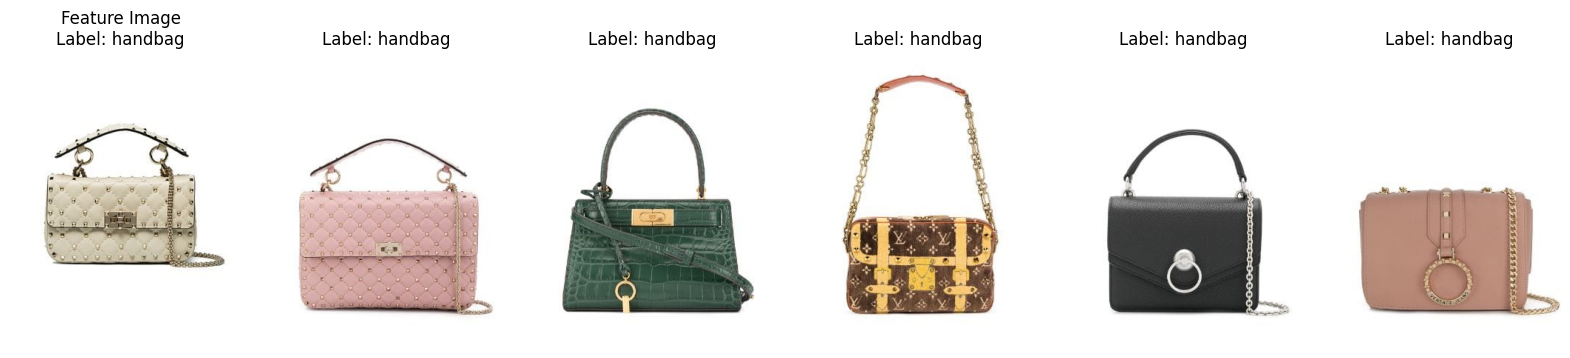

In [96]:
test_model(X_train_xception,y_train_xception,X_test_xception,y_test_xception,train_data,test_data,2)